## Package importation

In [ ]:
install.packages("regMMD")
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Rdpack’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(regMMD)
library(ggplot2)
library(gridExtra)
library(dplyr)


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Illustation of the contamination settings

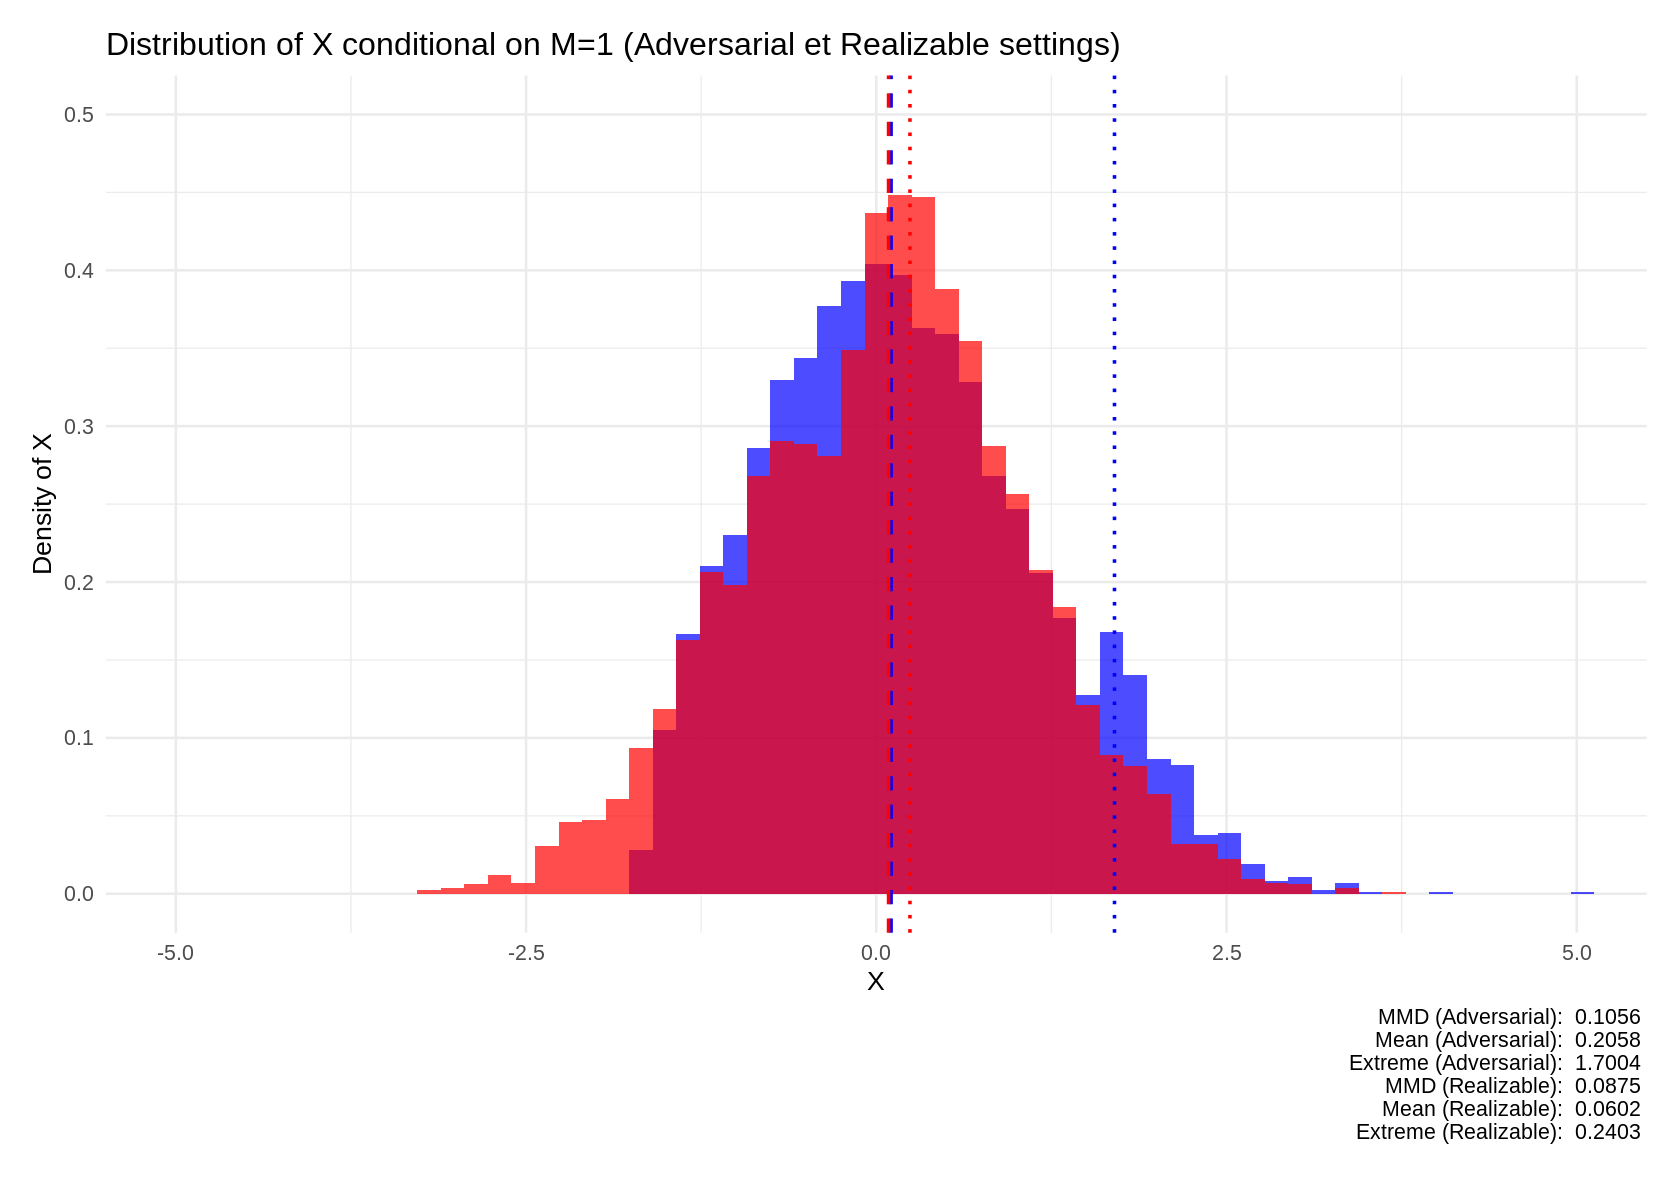

In [7]:
# Paramètres
n <- 10^4       # Nombre de points
alpha <- 0.5    # Paramètre de la Bernoulli
epsilon <- 0.1  # Proportion pour le second cas

# Exercice 1
# Générer X_i iid ~ N(0, 1)
X1 <- rnorm(n, 0, 1)

# Associer M_i iid ~ Bernoulli(alpha)
M1 <- rbinom(n, 1, alpha)

# Trouver les n*epsilon/2 plus grands et plus petits X_i
num_largest <- as.integer(n * epsilon / 2)
num_smallest <- as.integer(n * epsilon / 2)

# Indices des n*epsilon/2 plus grands X_i
indices_largest <- order(X1, decreasing = TRUE)[1:num_largest]

# Indices des n*epsilon/2 plus petits X_i
indices_smallest <- order(X1)[1:num_smallest]

# Attribuer M_i=1 aux plus grands X_i
M1[indices_largest] <- 1

# Attribuer M_i=0 aux plus petits X_i (pas besoin de changer, M_i est déjà 0 par défaut)
M1[indices_smallest] <- 0

# Calcul de la moyenne des X_i pour lesquels M_i=1
mean_X1_M1_1 <- mean(X1[M1 == 1])

# Calcul de la moyenne des extrêmes (min + max des X_i pour M_i=1)
extreme_values_X1 <- X1[M1 == 1]
mean_extreme_X1 <- (min(extreme_values_X1) + max(extreme_values_X1)) / 2

# Exercice 2
# Générer (1-epsilon)*n points X_i et M_i
n1 <- as.integer((1 - epsilon) * n)
X2_part1 <- rnorm(n1, 0, 1)
M2_part1 <- rbinom(n1, 1, alpha)

# Générer epsilon*n points X_i restants
n2 <- n - n1
X2_part2 <- rnorm(n2, 0, 1)

# Calculer le seuil
threshold2 <- 0  # Seuil fixé à 0

# Attribuer M_i=1 si X_i > threshold2 (seuil fixé à 0)
M2_part2 <- as.integer(X2_part2 > threshold2)

# Concaténer les deux parties
X2 <- c(X2_part1, X2_part2)
M2 <- c(M2_part1, M2_part2)

# Calcul de la moyenne des X_i pour lesquels M_i=1
mean_X2_M2_1 <- mean(X2[M2 == 1])

# Calcul de la moyenne des extrêmes (min + max des X_i pour M_i=1)
extreme_values_X2 <- X2[M2 == 1]
mean_extreme_X2 <- (min(extreme_values_X2) + max(extreme_values_X2)) / 2

# Estimations MMD pour les deux jeux de données
Est1 <- mmd_est(X1[M1 == 1], model="Gaussian.loc", par2=1)  # Adversarial
Est2 <- mmd_est(X2[M2 == 1], model="Gaussian.loc", par2=1)  # Realizable

# Récupérer les estimateurs MMD
mmd_estimator_X1 <- Est1$estimator  # MMD estimateur pour Adversarial
mmd_estimator_X2 <- Est2$estimator  # MMD estimateur pour Realizable

# Ajuster la taille de la fenêtre graphique
options(repr.plot.width = 14, repr.plot.height = 10)

# Tracer les fréquences des M_i en fonction des X_i pour les deux exercices
df1 <- data.frame(X = X1[M1 == 1], Group = 'Adversarial')
df2 <- data.frame(X = X2[M2 == 1], Group = 'Realizable')

# Création du graphique
ggplot() +
  geom_histogram(data = df1, aes(x = X, y = after_stat(density)), bins = 50, fill = 'blue', alpha = 0.7) +
  geom_histogram(data = df2, aes(x = X, y = after_stat(density)), bins = 50, fill = 'red', alpha = 0.7) +
  geom_vline(aes(xintercept = mean_extreme_X1), color = 'blue', linetype = 'dotted', linewidth = 1) +
  geom_vline(aes(xintercept = mean_extreme_X2), color = 'red', linetype = 'dotted', linewidth = 1) +
  # Ajouter les barres verticales pour les estimateurs MMD
  geom_vline(aes(xintercept = mmd_estimator_X1), color = 'blue', linetype = 'dashed', linewidth = 1) +
  geom_vline(aes(xintercept = mmd_estimator_X2), color = 'red', linetype = 'dashed', linewidth = 1) +
  labs(
    title = "Distribution of X conditional on M=1 (Adversarial et Realizable settings)",
    x = "X", y = "Density of X",
    caption = paste(
      "MMD (Adversarial): ", round(mmd_estimator_X1, 4), "\n",
      "Mean (Adversarial): ", round(mean_X1_M1_1, 4), "\n",
      "Extreme (Adversarial): ", round(mean_extreme_X1, 4), "\n",
      "MMD (Realizable): ", round(mmd_estimator_X2, 4), "\n",
      "Mean (Realizable): ", round(mean_X2_M2_1, 4), "\n",
      "Extreme (Realizable): ", round(mean_extreme_X2, 4), "\n"
    )
  ) +
  theme_minimal(base_size = 16) +  # Augmenter la taille de base du texte
  theme(
    legend.position = 'top',
    plot.margin = margin(20, 20, 20, 20)  # Marges plus larges pour plus d'espace
  ) +
  scale_fill_manual(name = "Group", values = c('blue', 'red')) +
  guides(fill = guide_legend(title = "Group")) +
  coord_cartesian(xlim = c(-5, 5), ylim = c(0, 0.5))  # Zoom sur la plage X entre -5 et 5 et Y entre 0 et 0.5)

## Distribution of the three estimators in the two settings

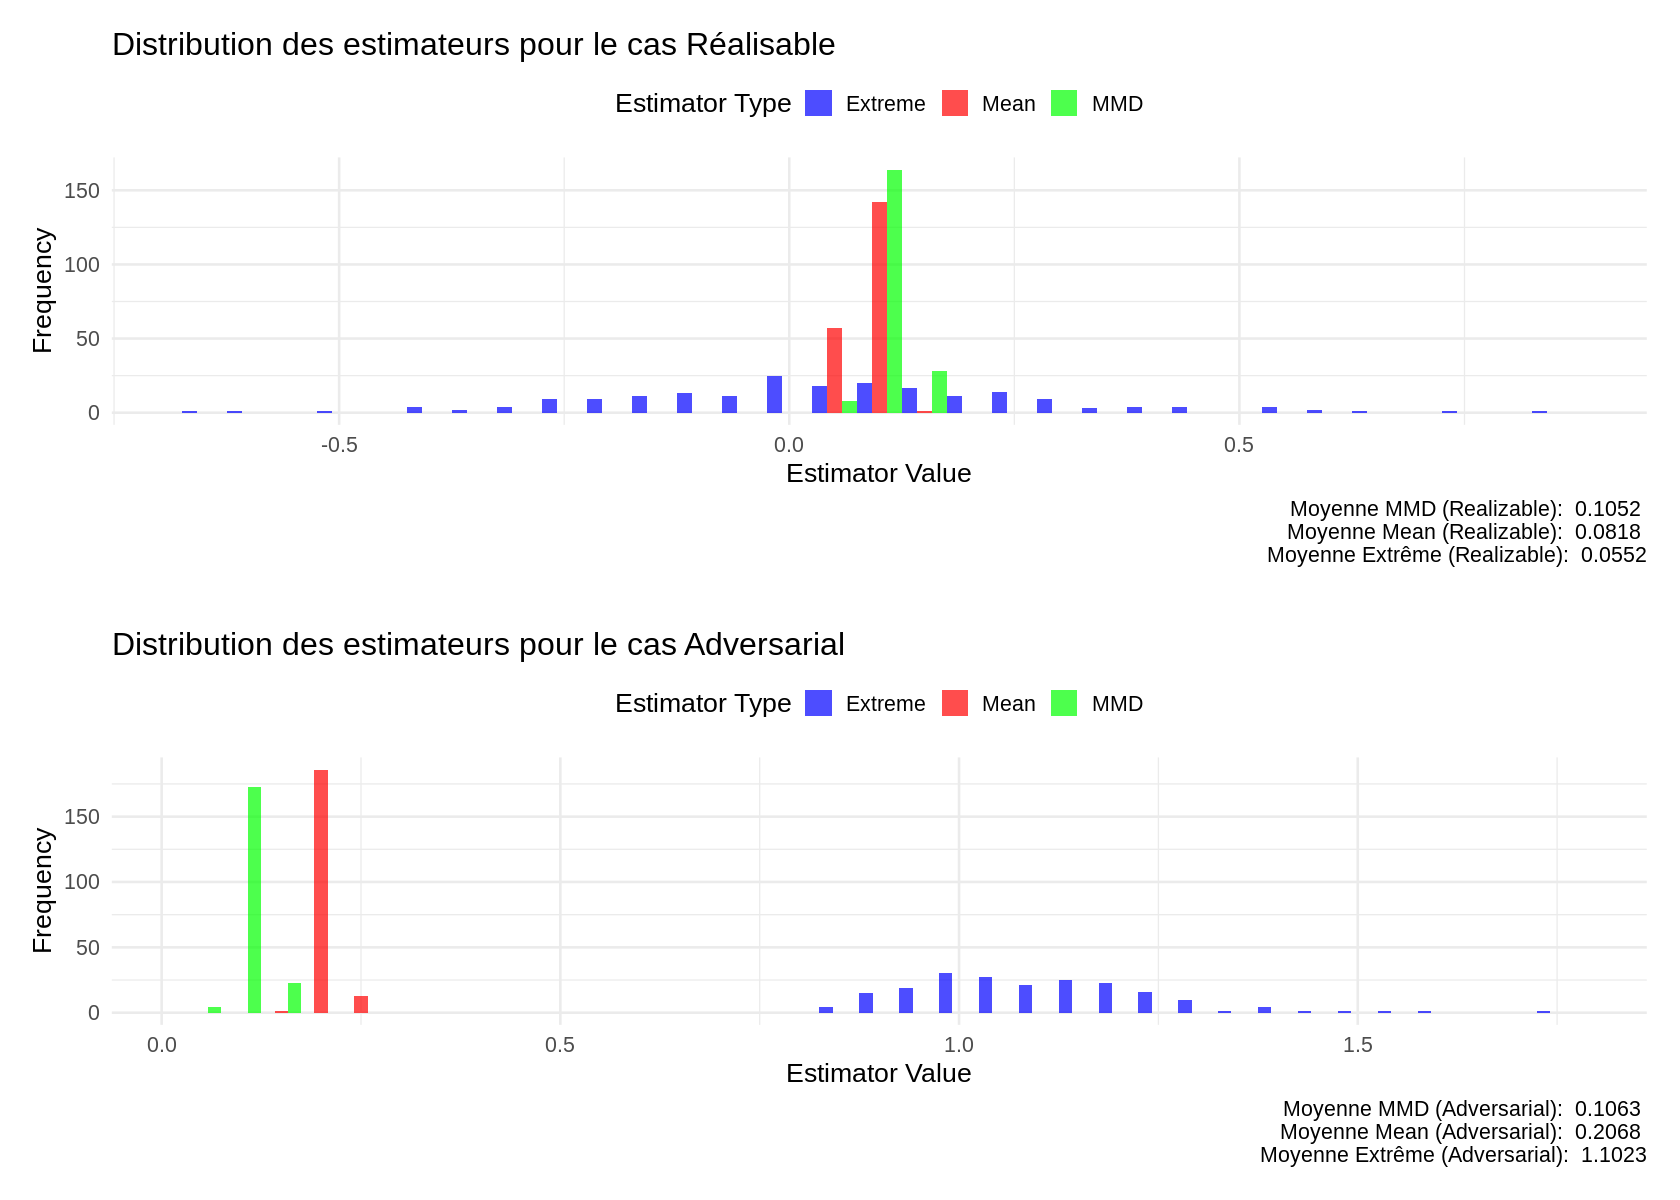

In [ ]:
# Paramètres
n <- 10^4       # Nombre de points
alpha <- 0.5    # Paramètre de la Bernoulli
epsilon <- 0.1  # Proportion pour le second cas
num_repetitions <- 200  # Nombre de répétitions

# Fonction pour exécuter l'expérience pour le cas Réalisable
run_experiment_realisable <- function(n, alpha, epsilon) {
  # Exercice 2 (Realizable seulement)
  n1 <- as.integer((1 - epsilon) * n)
  X2_part1 <- rnorm(n1, 0, 1)
  M2_part1 <- rbinom(n1, 1, alpha)

  n2 <- n - n1
  X2_part2 <- rnorm(n2, 0, 1)
  M2_part2 <- as.integer(X2_part2 > 0)

  X2 <- c(X2_part1, X2_part2)
  M2 <- c(M2_part1, M2_part2)

  # Estimations MMD pour le cas réalisable
  Est2 <- mmd_est(X2[M2 == 1], model="Gaussian.loc", par2=1)  # Realizable

  # Estimateur de la moyenne pour le cas réalisable
  mean_X2 <- mean(X2[M2 == 1])

  # Estimateur extrême (moyenne des extrêmes) pour le cas réalisable
  extreme_X2 <- (max(X2[M2 == 1]) + min(X2[M2 == 1])) / 2

  # Retourner les estimateurs MMD, moyenne et extrêmes pour le cas réalisable
  return(list(mmd_estimator_X2 = Est2$estimator,
              mean_X2 = mean_X2, extreme_X2 = extreme_X2))
}

# Fonction pour exécuter l'expérience pour le cas Adversarial
run_experiment_adversarial <- function(n, alpha, epsilon) {
  # Exercice 1 (Adversarial seulement)
  X1 <- rnorm(n, 0, 1)
  M1 <- rbinom(n, 1, alpha)

  num_largest <- as.integer(n * epsilon / 2)
  num_smallest <- as.integer(n * epsilon / 2)

  indices_largest <- order(X1, decreasing = TRUE)[1:num_largest]
  indices_smallest <- order(X1)[1:num_smallest]

  M1[indices_largest] <- 1
  M1[indices_smallest] <- 0

  # Estimations MMD pour le cas adversarial
  Est1 <- mmd_est(X1[M1 == 1], model="Gaussian.loc", par2=1)  # Adversarial

  # Estimateur de la moyenne pour le cas adversarial
  mean_X1 <- mean(X1[M1 == 1])

  # Estimateur extrême (moyenne des extrêmes) pour le cas adversarial
  extreme_X1 <- (max(X1[M1 == 1]) + min(X1[M1 == 1])) / 2

  # Retourner les estimateurs MMD, moyenne et extrêmes pour le cas adversarial
  return(list(mmd_estimator_X1 = Est1$estimator,
              mean_X1 = mean_X1, extreme_X1 = extreme_X1))
}

# Répéter l'expérience 500 fois et stocker les résultats pour le cas réalisable et adversarial
mmd_estimators_X2 <- numeric(num_repetitions)
mean_estimators_X2 <- numeric(num_repetitions)
extreme_estimators_X2 <- numeric(num_repetitions)

mmd_estimators_X1 <- numeric(num_repetitions)
mean_estimators_X1 <- numeric(num_repetitions)
extreme_estimators_X1 <- numeric(num_repetitions)

for (i in 1:num_repetitions) {
  result_realisable <- run_experiment_realisable(n, alpha, epsilon)
  result_adversarial <- run_experiment_adversarial(n, alpha, epsilon)

  mmd_estimators_X2[i] <- result_realisable$mmd_estimator_X2
  mean_estimators_X2[i] <- result_realisable$mean_X2
  extreme_estimators_X2[i] <- result_realisable$extreme_X2

  mmd_estimators_X1[i] <- result_adversarial$mmd_estimator_X1
  mean_estimators_X1[i] <- result_adversarial$mean_X1
  extreme_estimators_X1[i] <- result_adversarial$extreme_X1
}

# Création des dataframes pour les graphes
df_estimators_realisable <- data.frame(
  Estimator_Value = c(mmd_estimators_X2, mean_estimators_X2, extreme_estimators_X2),
  Estimator_Type = rep(c('MMD', 'Mean', 'Extreme'), each = num_repetitions),
  Setting = rep('Realizable', each = num_repetitions * 3)
)

df_estimators_adversarial <- data.frame(
  Estimator_Value = c(mmd_estimators_X1, mean_estimators_X1, extreme_estimators_X1),
  Estimator_Type = rep(c('MMD', 'Mean', 'Extreme'), each = num_repetitions),
  Setting = rep('Adversarial', each = num_repetitions * 3)
)

# Combine les deux dataframes pour les plots
df_estimators_combined <- rbind(df_estimators_realisable, df_estimators_adversarial)

# Tracer les deux graphes l'un au dessus de l'autre
plot_realisable <- ggplot(df_estimators_realisable, aes(x = Estimator_Value, fill = Estimator_Type)) +
  geom_histogram(binwidth = 0.05, alpha = 0.7, position = 'dodge') +
  labs(
    title = "Distribution des estimateurs pour le cas Réalisable",
    x = "Estimator Value",
    y = "Frequency",
    caption = paste(
      "Moyenne MMD (Realizable): ", round(mean(mmd_estimators_X2), 4), "\n",
      "Moyenne Mean (Realizable): ", round(mean(mean_estimators_X2), 4), "\n",
      "Moyenne Extrême (Realizable): ", round(mean(extreme_estimators_X2), 4)
    )
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = 'top',
    plot.margin = margin(20, 20, 20, 20)
  ) +
  scale_fill_manual(name = "Estimator Type", values = c('blue', 'red', 'green')) +
  guides(fill = guide_legend(title = "Estimator Type"))

plot_adversarial <- ggplot(df_estimators_adversarial, aes(x = Estimator_Value, fill = Estimator_Type)) +
  geom_histogram(binwidth = 0.05, alpha = 0.7, position = 'dodge') +
  labs(
    title = "Distribution des estimateurs pour le cas Adversarial",
    x = "Estimator Value",
    y = "Frequency",
    caption = paste(
      "Moyenne MMD (Adversarial): ", round(mean(mmd_estimators_X1), 4), "\n",
      "Moyenne Mean (Adversarial): ", round(mean(mean_estimators_X1), 4), "\n",
      "Moyenne Extrême (Adversarial): ", round(mean(extreme_estimators_X1), 4)
    )
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = 'top',
    plot.margin = margin(20, 20, 20, 20)
  ) +
  scale_fill_manual(name = "Estimator Type", values = c('blue', 'red', 'green')) +
  guides(fill = guide_legend(title = "Estimator Type"))

# Affichage des deux plots
grid.arrange(plot_realisable, plot_adversarial, ncol = 1)

In [ ]:
# Calcul de l'EQM pour chaque estimateur
calculate_rmse <- function(estimators) {
  return(mean(estimators^2))
}

# Calcul de l'EQM pour les estimateurs dans les répétitions
rmse_mmd_X1 <- calculate_rmse(mmd_estimators_X1)
rmse_mean_X1 <- calculate_rmse(mean_estimators_X1)
rmse_extreme_X1 <- calculate_rmse(extreme_estimators_X1)

rmse_mmd_X2 <- calculate_rmse(mmd_estimators_X2)
rmse_mean_X2 <- calculate_rmse(mean_estimators_X2)
rmse_extreme_X2 <- calculate_rmse(extreme_estimators_X2)

# Affichage des résultats de l'EQM
cat("Erreur quadratique moyenne (Realizable) - MMD: ", rmse_mmd_X2, "\n")
cat("Erreur quadratique moyenne (Adversarial) - MMD: ", rmse_mmd_X1, "\n")

cat("Erreur quadratique moyenne (Realizable) - Mean: ", rmse_mean_X2, "\n")
cat("Erreur quadratique moyenne (Adversarial) - Mean: ", rmse_mean_X1, "\n")

cat("Erreur quadratique moyenne (Realizable) - Extreme: ", rmse_extreme_X2, "\n")
cat("Erreur quadratique moyenne (Adversarial) - Extreme: ", rmse_extreme_X1, "\n")

Erreur quadratique moyenne (Realizable) - MMD:  0.01094556 
Erreur quadratique moyenne (Adversarial) - MMD:  0.01162362 
Erreur quadratique moyenne (Realizable) - Mean:  0.006537419 
Erreur quadratique moyenne (Adversarial) - Mean:  0.04315111 
Erreur quadratique moyenne (Realizable) - Extreme:  0.04477988 
Erreur quadratique moyenne (Adversarial) - Extreme:  1.252509 


## Evolution of the MLE as a function of n

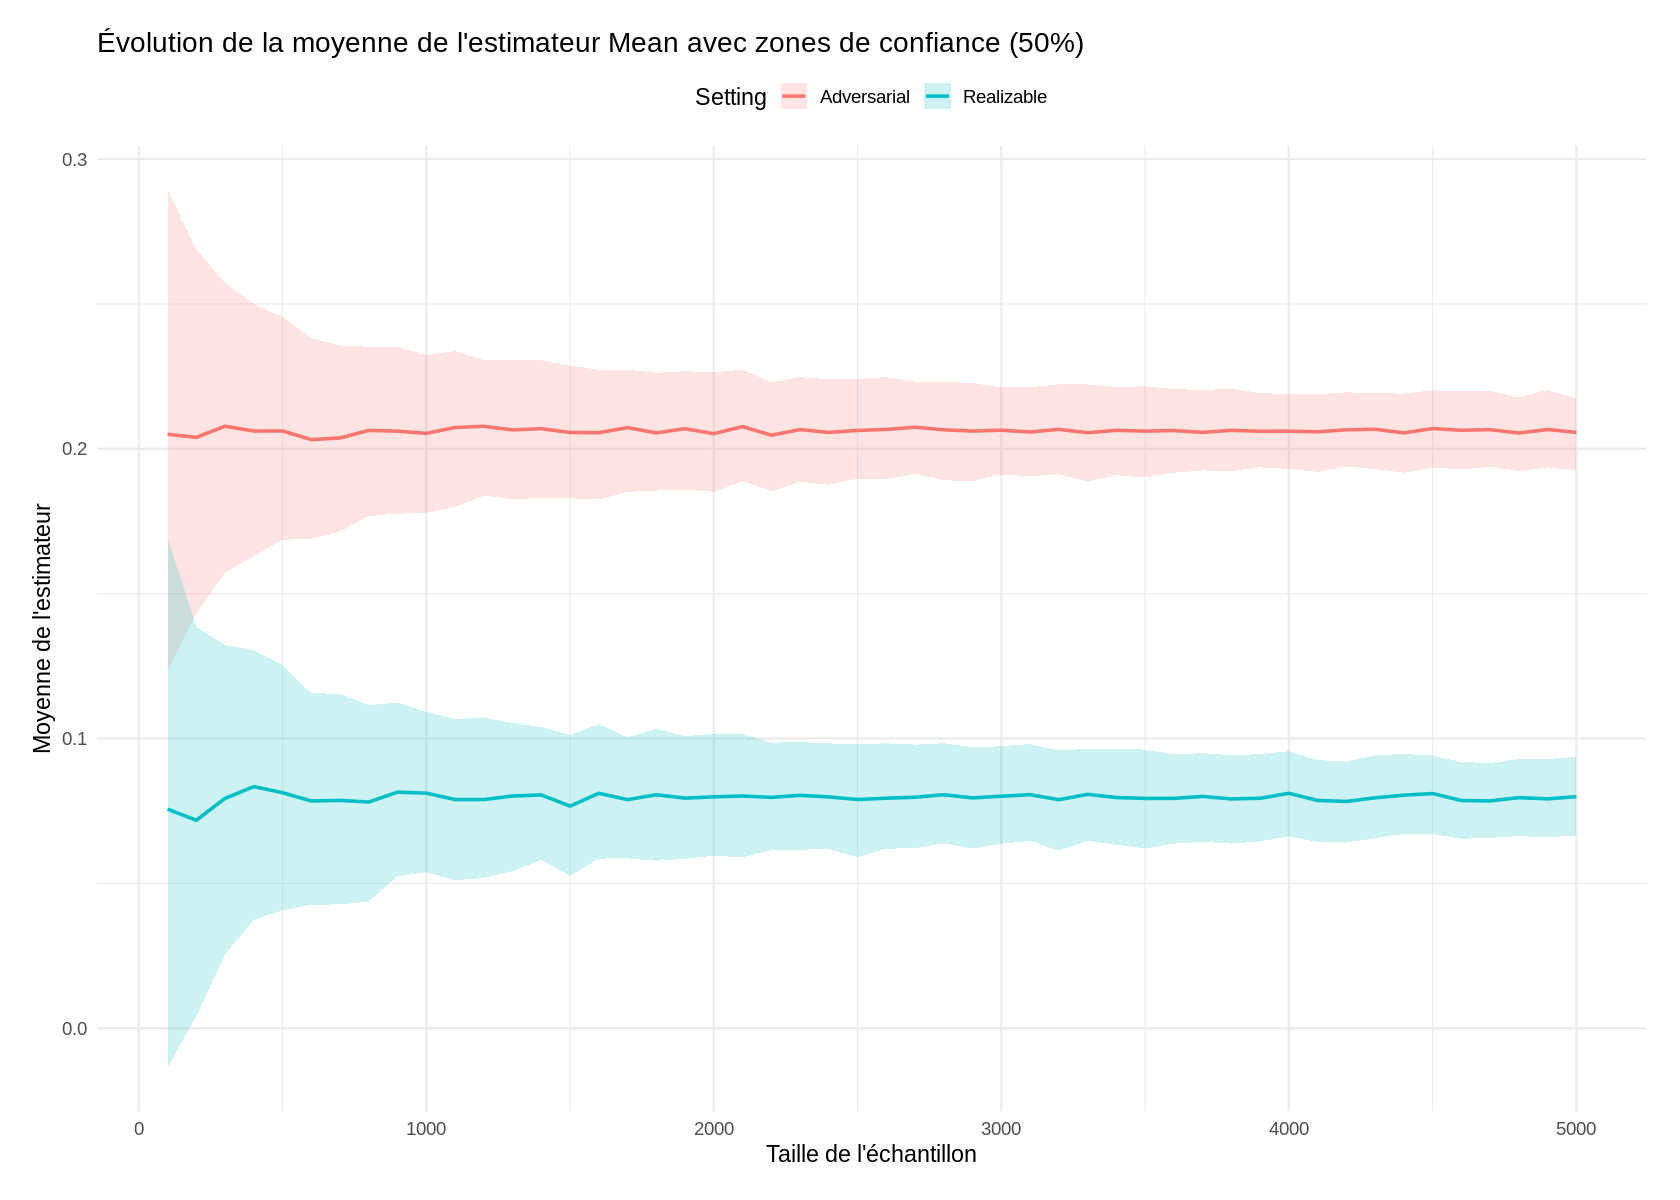

In [ ]:
# Fonction pour calculer les quartiles de l'estimateur Mean (cas adversarial)
calculate_mean_quartiles_adversarial <- function(n, num_repetitions, alpha, epsilon) {
  mean_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimateur Mean
    mean_estimators[i] <- mean(X[M == 1])
  }

  mean_val <- mean(mean_estimators)
  lower_quartile <- quantile(mean_estimators, 0.25)
  upper_quartile <- quantile(mean_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur Mean (cas réalisable)
calculate_mean_quartiles_realizable <- function(n, num_repetitions, alpha, epsilon) {
  mean_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimateur Mean
    mean_estimators[i] <- mean(X[M == 1])
  }

  mean_val <- mean(mean_estimators)
  lower_quartile <- quantile(mean_estimators, 0.25)
  upper_quartile <- quantile(mean_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Paramètres
sample_sizes <- seq(100, 5000, by = 100)  # Tailles d'échantillon
num_repetitions <- 1000  # Nombre de répétitions pour chaque taille
alpha <- 0.5
epsilon <- 0.1

# Calcul des moyennes et des quartiles pour chaque taille d'échantillon
results_adversarial <- t(sapply(sample_sizes, calculate_mean_quartiles_adversarial, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))
results_realizable <- t(sapply(sample_sizes, calculate_mean_quartiles_realizable, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))

# Préparer les données pour le graphique
df <- data.frame(
  SampleSize = rep(sample_sizes, 2),
  MeanEstimator = c(results_adversarial[, 1], results_realizable[, 1]),
  CI_Lower = c(results_adversarial[, 2], results_realizable[, 2]),
  CI_Upper = c(results_adversarial[, 3], results_realizable[, 3]),
  Setting = rep(c("Adversarial", "Realizable"), each = length(sample_sizes))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
ggplot(df, aes(x = SampleSize, y = MeanEstimator, color = Setting, fill = Setting)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution de la moyenne de l'estimateur Mean avec zones de confiance (50%)",
    x = "Taille de l'échantillon",
    y = "Moyenne de l'estimateur",
    color = "Setting",
    fill = "Setting"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )

## Evolution of the AE as a function of n

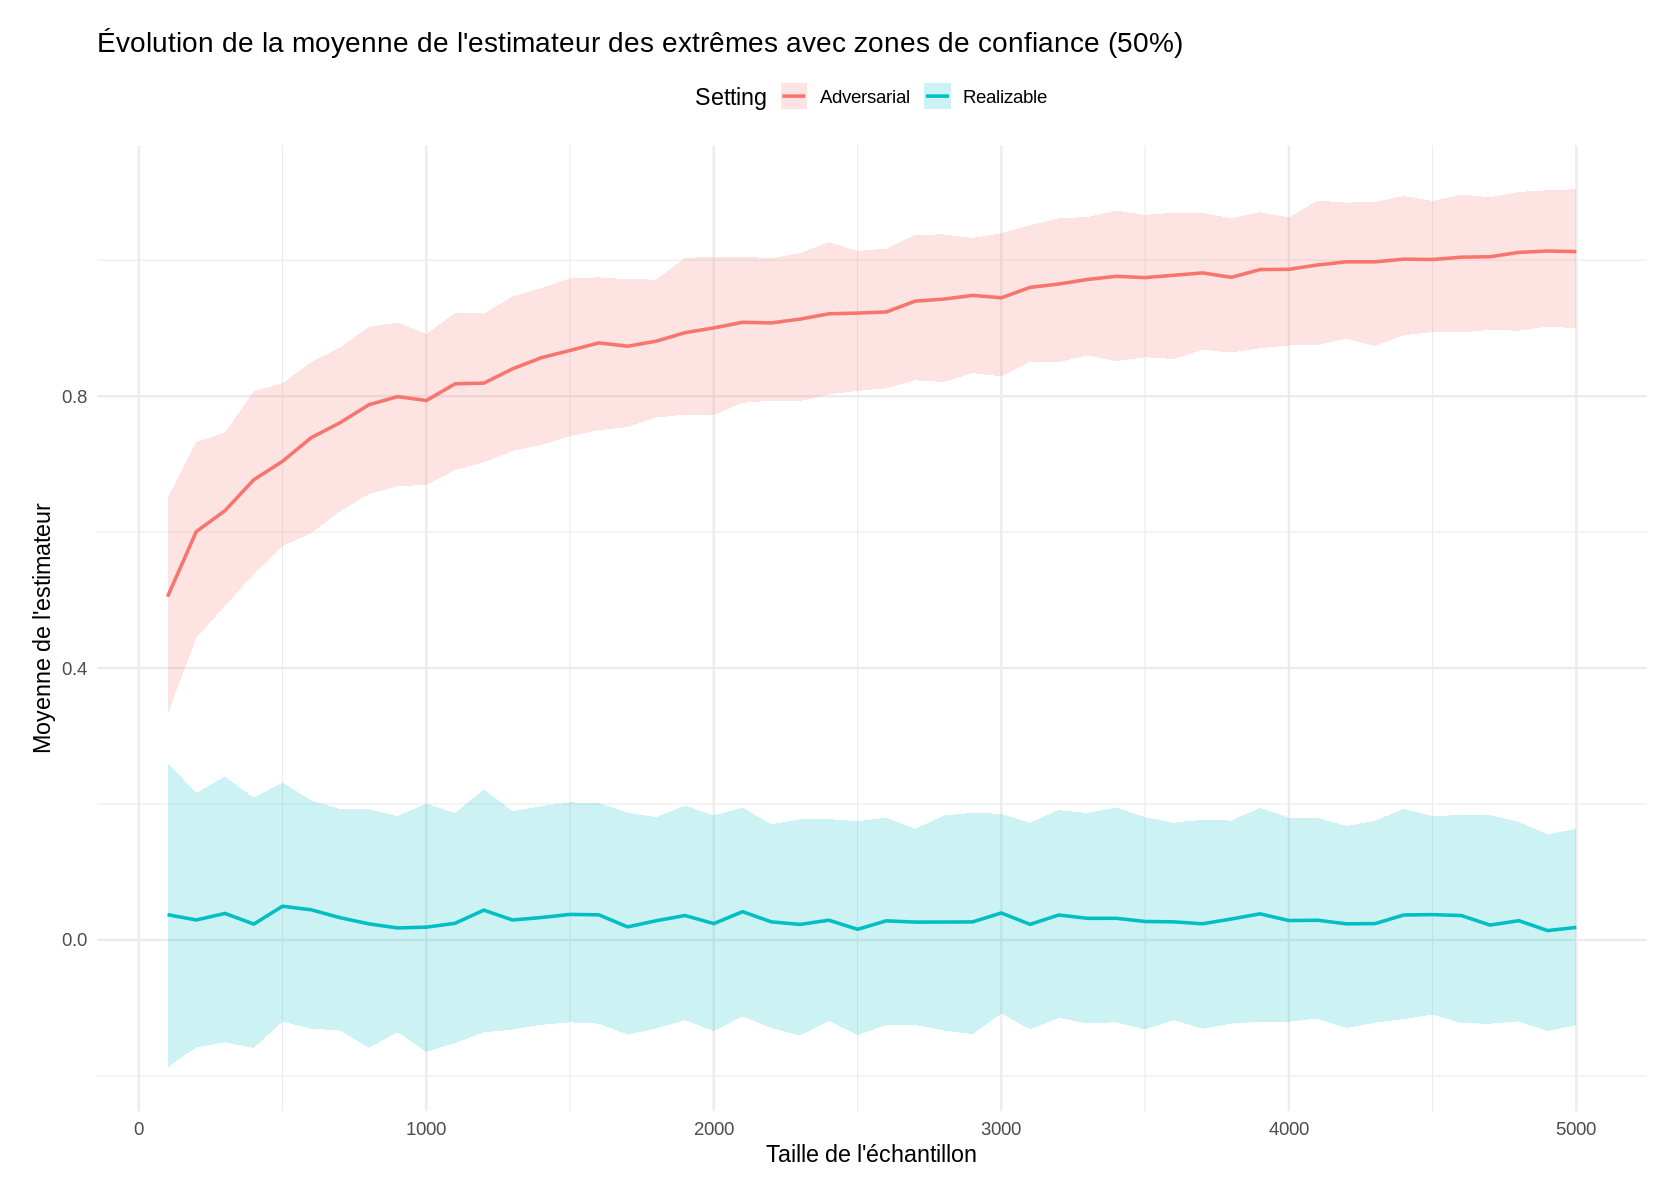

In [ ]:
# Fonction pour calculer les quartiles de l'estimateur des extrêmes (Adversarial et Realizable)
calculate_extreme_mean_quartiles <- function(n, num_repetitions, alpha, epsilon, setting) {
  extreme_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    if (setting == "Adversarial") {
      # Cadre adversarial
      X <- rnorm(n, 0, 1)
      M <- rbinom(n, 1, alpha)

      num_largest <- as.integer(n * epsilon / 2)
      num_smallest <- as.integer(n * epsilon / 2)

      indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
      indices_smallest <- order(X)[1:num_smallest]

      M[indices_largest] <- 1
      M[indices_smallest] <- 0
    } else {
      # Cadre réalisable
      n1 <- as.integer((1 - epsilon) * n)
      X1 <- rnorm(n1, 0, 1)
      M1 <- rbinom(n1, 1, alpha)

      n2 <- n - n1
      X2 <- rnorm(n2, 0, 1)
      M2 <- as.integer(X2 > 0)

      X <- c(X1, X2)
      M <- c(M1, M2)
    }

    # Estimation des extrêmes (maximum et minimum)
    max_value <- max(X[M == 1])
    min_value <- min(X[M == 1])

    # Moyenne des extrêmes
    extreme_estimators[i] <- (max_value + min_value) / 2
  }

  extreme_val <- mean(extreme_estimators)
  lower_quartile <- quantile(extreme_estimators, 0.25)
  upper_quartile <- quantile(extreme_estimators, 0.75)

  return(c(extreme_val, lower_quartile, upper_quartile))
}

# Paramètres
sample_sizes <- seq(100, 5000, by = 100)  # Tailles d'échantillon
num_repetitions <- 1000  # Nombre de répétitions pour chaque taille
alpha <- 0.5
epsilon <- 0.1

# Calcul des moyennes et des quartiles pour chaque taille d'échantillon pour l'estimateur des extrêmes
results_adversarial_extreme <- t(sapply(sample_sizes, calculate_extreme_mean_quartiles, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon, setting = "Adversarial"))
results_realizable_extreme <- t(sapply(sample_sizes, calculate_extreme_mean_quartiles, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon, setting = "Realizable"))

# Préparer les données pour le graphique
df_extreme <- data.frame(
  SampleSize = rep(sample_sizes, 2),
  MeanEstimator = c(results_adversarial_extreme[, 1], results_realizable_extreme[, 1]),
  CI_Lower = c(results_adversarial_extreme[, 2], results_realizable_extreme[, 2]),
  CI_Upper = c(results_adversarial_extreme[, 3], results_realizable_extreme[, 3]),
  Setting = rep(c("Adversarial", "Realizable"), each = length(sample_sizes))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
library(ggplot2)
ggplot(df_extreme, aes(x = SampleSize, y = MeanEstimator, color = Setting, fill = Setting)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution de la moyenne de l'estimateur des extrêmes avec zones de confiance (50%)",
    x = "Taille de l'échantillon",
    y = "Moyenne de l'estimateur",
    color = "Setting",
    fill = "Setting"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )

## Evolution of the MMD as a function of n

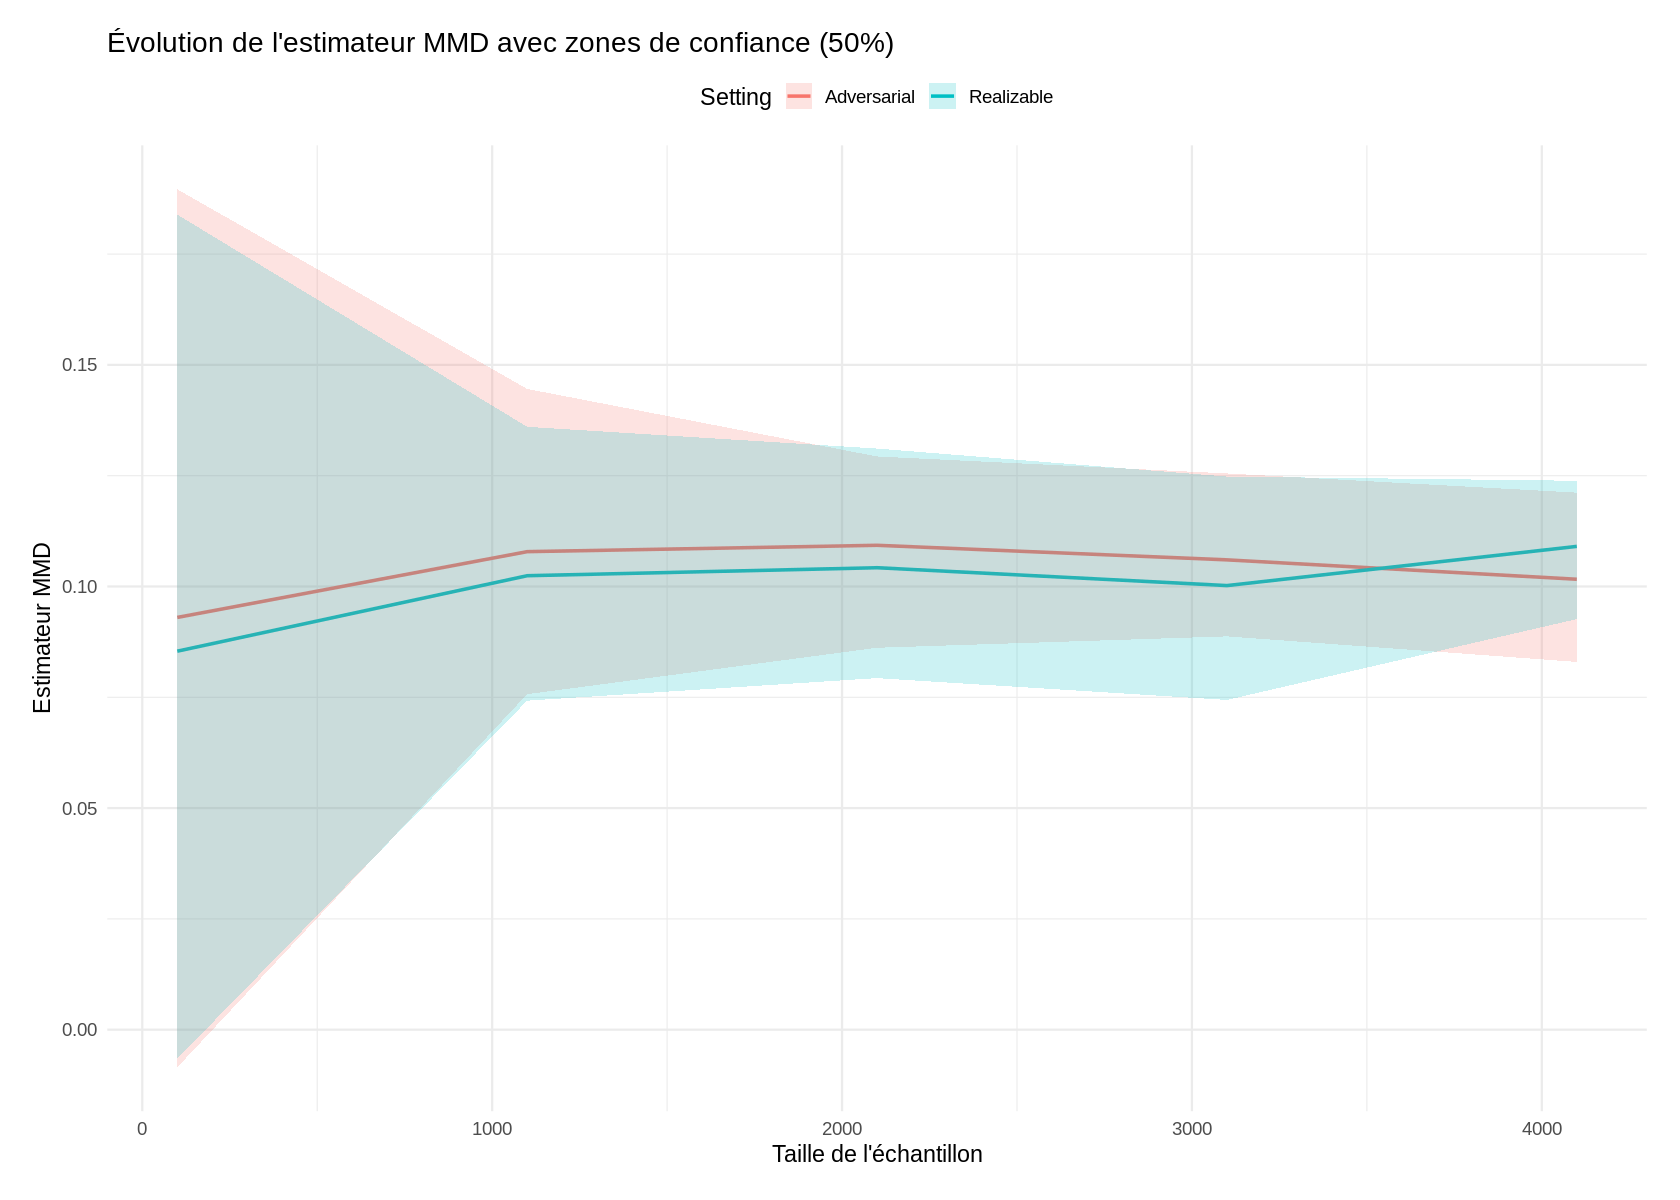

In [ ]:
# Fonction pour calculer les quartiles de l'estimateur MMD (cas adversarial)
calculate_mmd_quartiles_adversarial <- function(n, num_repetitions, alpha, epsilon) {
  mmd_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    X <- rnorm(n, 0, 1)  # Génération des données adversariales
    M <- rbinom(n, 1, alpha)

    # Adversarial noise: modifier M pour forcer des valeurs extrêmes
    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimateur MMD
    Est1 <- mmd_est(X[M == 1], model = "Gaussian.loc", par2 = 1)
    mmd_estimators[i] <- Est1$estimator
  }

  mean_val <- mean(mmd_estimators)
  lower_quartile <- quantile(mmd_estimators, 0.25)
  upper_quartile <- quantile(mmd_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur MMD (cas réalisable)
calculate_mmd_quartiles_realizable <- function(n, num_repetitions, alpha, epsilon) {
  mmd_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)  # Données réalisables
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)  # Données restantes
    M2 <- as.integer(X2 > 0)  # Indicateur réalisable

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimateur MMD
    Est1 <- mmd_est(X[M == 1], model = "Gaussian.loc", par2 = 1)
    mmd_estimators[i] <- Est1$estimator
  }

  mean_val <- mean(mmd_estimators)
  lower_quartile <- quantile(mmd_estimators, 0.25)
  upper_quartile <- quantile(mmd_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Paramètres
sample_sizes <- seq(100, 5000, by = 1000)  # Tailles d'échantillon
num_repetitions <- 100  # Nombre de répétitions
alpha <- 0.5
epsilon <- 0.1

# Calcul des moyennes et des quartiles pour chaque taille d'échantillon
results_adversarial <- t(sapply(sample_sizes, calculate_mmd_quartiles_adversarial, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))
results_realizable <- t(sapply(sample_sizes, calculate_mmd_quartiles_realizable, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))

# Préparer les données pour le graphique
df <- data.frame(
  SampleSize = rep(sample_sizes, 2),
  MMD_Estimator = c(results_adversarial[, 1], results_realizable[, 1]),
  CI_Lower = c(results_adversarial[, 2], results_realizable[, 2]),
  CI_Upper = c(results_adversarial[, 3], results_realizable[, 3]),
  Setting = rep(c("Adversarial", "Realizable"), each = length(sample_sizes))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
library(ggplot2)

ggplot(df, aes(x = SampleSize, y = MMD_Estimator, color = Setting, fill = Setting)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution de l'estimateur MMD avec zones de confiance (50%)",
    x = "Taille de l'échantillon",
    y = "Estimateur MMD",
    color = "Setting",
    fill = "Setting"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )

## Evolution of the estimators with n in the realizable setting

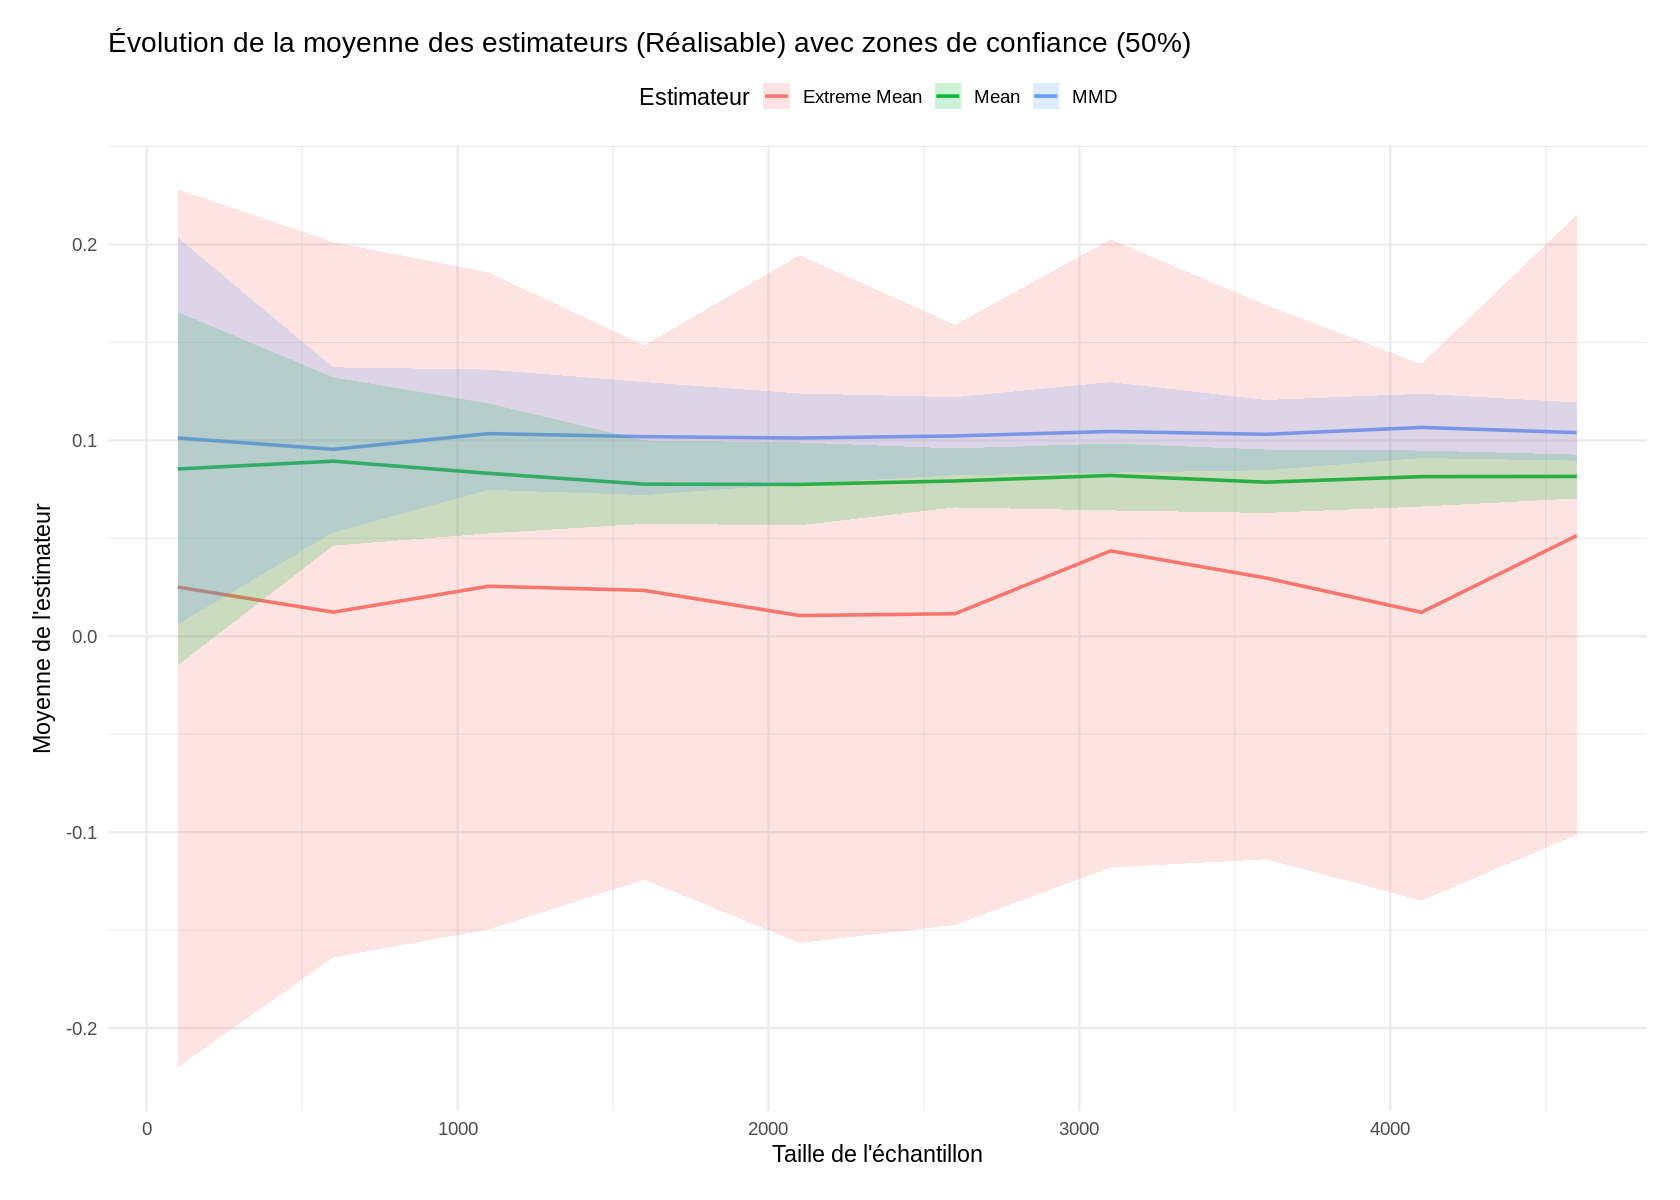

In [9]:
# Fonction pour calculer les quartiles de l'estimateur Mean (cas réalisable)
calculate_mean_quartiles_realizable <- function(n, num_repetitions, alpha, epsilon) {
  mean_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    # Génération des données pour le cas réalisable
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimateur Mean
    mean_estimators[i] <- mean(X[M == 1])
  }

  mean_val <- mean(mean_estimators)
  lower_quartile <- quantile(mean_estimators, 0.25)
  upper_quartile <- quantile(mean_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur des extrêmes (cas réalisable)
calculate_extreme_mean_quartiles_realizable <- function(n, num_repetitions, alpha, epsilon) {
  extreme_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    # Génération des données pour le cas réalisable
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimation des extrêmes (maximum et minimum)
    max_value <- max(X[M == 1])
    min_value <- min(X[M == 1])

    # Moyenne des extrêmes
    extreme_estimators[i] <- (max_value + min_value) / 2
  }

  extreme_val <- mean(extreme_estimators)
  lower_quartile <- quantile(extreme_estimators, 0.25)
  upper_quartile <- quantile(extreme_estimators, 0.75)

  return(c(extreme_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur MMD (cas réalisable)
calculate_mmd_quartiles_realizable <- function(n, num_repetitions, alpha, epsilon) {
  mmd_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    # Génération des données pour le cas réalisable
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimateur MMD
    Est1 <- mmd_est(X[M == 1], model = "Gaussian.loc", par2 = 1)
    mmd_estimators[i] <- Est1$estimator
  }

  mmd_val <- mean(mmd_estimators)
  lower_quartile <- quantile(mmd_estimators, 0.25)
  upper_quartile <- quantile(mmd_estimators, 0.75)

  return(c(mmd_val, lower_quartile, upper_quartile))
}

# Paramètres
sample_sizes <- seq(100, 5000, by = 500)  # Tailles d'échantillon
num_repetitions <- 200  # Nombre de répétitions pour chaque taille
alpha <- 0.5
epsilon <- 0.1

# Calcul des moyennes et des quartiles pour chaque taille d'échantillon
results_mean_realizable <- t(sapply(sample_sizes, calculate_mean_quartiles_realizable, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))
results_extreme_realizable <- t(sapply(sample_sizes, calculate_extreme_mean_quartiles_realizable, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))
results_mmd_realizable <- t(sapply(sample_sizes, calculate_mmd_quartiles_realizable, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))

# Préparer les données pour le graphique
df_realizable <- data.frame(
  SampleSize = rep(sample_sizes, 3),
  MeanEstimator = c(
    results_mean_realizable[, 1],
    results_extreme_realizable[, 1],
    results_mmd_realizable[, 1]
  ),
  CI_Lower = c(
    results_mean_realizable[, 2],
    results_extreme_realizable[, 2],
    results_mmd_realizable[, 2]
  ),
  CI_Upper = c(
    results_mean_realizable[, 3],
    results_extreme_realizable[, 3],
    results_mmd_realizable[, 3]
  ),
  Estimator = rep(c("Mean", "Extreme Mean", "MMD"), each = length(sample_sizes))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
ggplot(df_realizable, aes(x = SampleSize, y = MeanEstimator, color = Estimator, fill = Estimator)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution de la moyenne des estimateurs (Réalisable) avec zones de confiance (50%)",
    x = "Taille de l'échantillon",
    y = "Moyenne de l'estimateur",
    color = "Estimateur",
    fill = "Estimateur"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )

## Evolution of the estimators with n in the adversarial setting

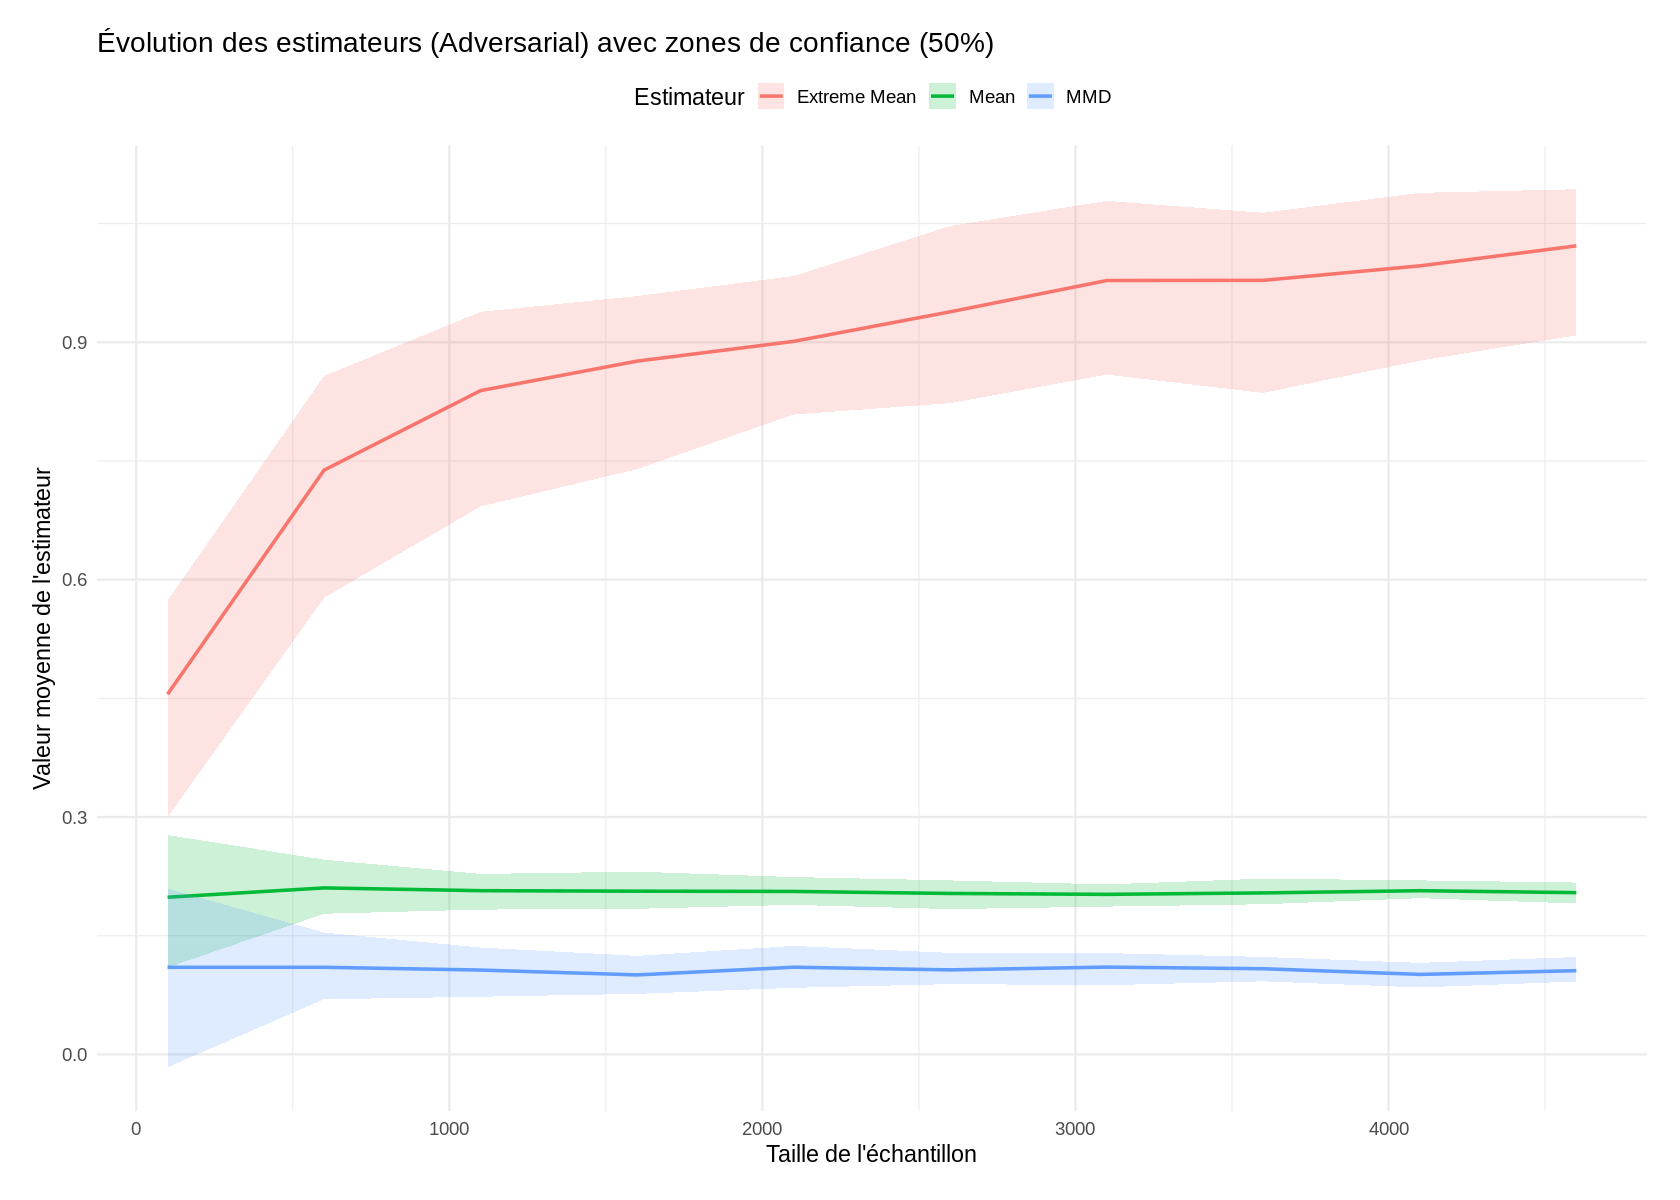

In [ ]:
# Fonction pour calculer les quartiles de l'estimateur Mean (Adversarial)
calculate_mean_quartiles_adversarial <- function(n, num_repetitions, alpha, epsilon) {
  mean_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimateur Mean
    mean_estimators[i] <- mean(X[M == 1])
  }

  mean_val <- mean(mean_estimators)
  lower_quartile <- quantile(mean_estimators, 0.25)
  upper_quartile <- quantile(mean_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur des extrêmes (Adversarial)
calculate_extreme_mean_quartiles_adversarial <- function(n, num_repetitions, alpha, epsilon) {
  extreme_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimation des extrêmes (maximum et minimum)
    max_value <- max(X[M == 1])
    min_value <- min(X[M == 1])

    # Moyenne des extrêmes
    extreme_estimators[i] <- (max_value + min_value) / 2
  }

  extreme_val <- mean(extreme_estimators)
  lower_quartile <- quantile(extreme_estimators, 0.25)
  upper_quartile <- quantile(extreme_estimators, 0.75)

  return(c(extreme_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur MMD (Adversarial)
calculate_mmd_quartiles_adversarial <- function(n, num_repetitions, alpha, epsilon) {
  mmd_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimateur MMD
    Est1 <- mmd_est(X[M == 1], model = "Gaussian.loc", par2 = 1)
    mmd_estimators[i] <- Est1$estimator
  }

  mmd_val <- mean(mmd_estimators)
  lower_quartile <- quantile(mmd_estimators, 0.25)
  upper_quartile <- quantile(mmd_estimators, 0.75)

  return(c(mmd_val, lower_quartile, upper_quartile))
}

# Paramètres
sample_sizes <- seq(100, 5000, by = 500)  # Tailles d'échantillon
num_repetitions <- 100  # Nombre de répétitions pour chaque taille
alpha <- 0.5
epsilon <- 0.1

# Calcul des moyennes et des quartiles pour chaque taille d'échantillon
results_mean_adversarial <- t(sapply(sample_sizes, calculate_mean_quartiles_adversarial, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))
results_extreme_adversarial <- t(sapply(sample_sizes, calculate_extreme_mean_quartiles_adversarial, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))
results_mmd_adversarial <- t(sapply(sample_sizes, calculate_mmd_quartiles_adversarial, num_repetitions = num_repetitions, alpha = alpha, epsilon = epsilon))

# Préparer les données pour le graphique
df_adversarial <- data.frame(
  SampleSize = rep(sample_sizes, 3),
  MeanEstimator = c(results_mean_adversarial[, 1], results_extreme_adversarial[, 1], results_mmd_adversarial[, 1]),
  CI_Lower = c(results_mean_adversarial[, 2], results_extreme_adversarial[, 2], results_mmd_adversarial[, 2]),
  CI_Upper = c(results_mean_adversarial[, 3], results_extreme_adversarial[, 3], results_mmd_adversarial[, 3]),
  Estimator = rep(c("Mean", "Extreme Mean", "MMD"), each = length(sample_sizes))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
library(ggplot2)
ggplot(df_adversarial, aes(x = SampleSize, y = MeanEstimator, color = Estimator, fill = Estimator)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution des estimateurs (Adversarial) avec zones de confiance (50%)",
    x = "Taille de l'échantillon",
    y = "Valeur moyenne de l'estimateur",
    color = "Estimateur",
    fill = "Estimateur"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )

## Evolution of the estimators with ɛ in the realizable setting

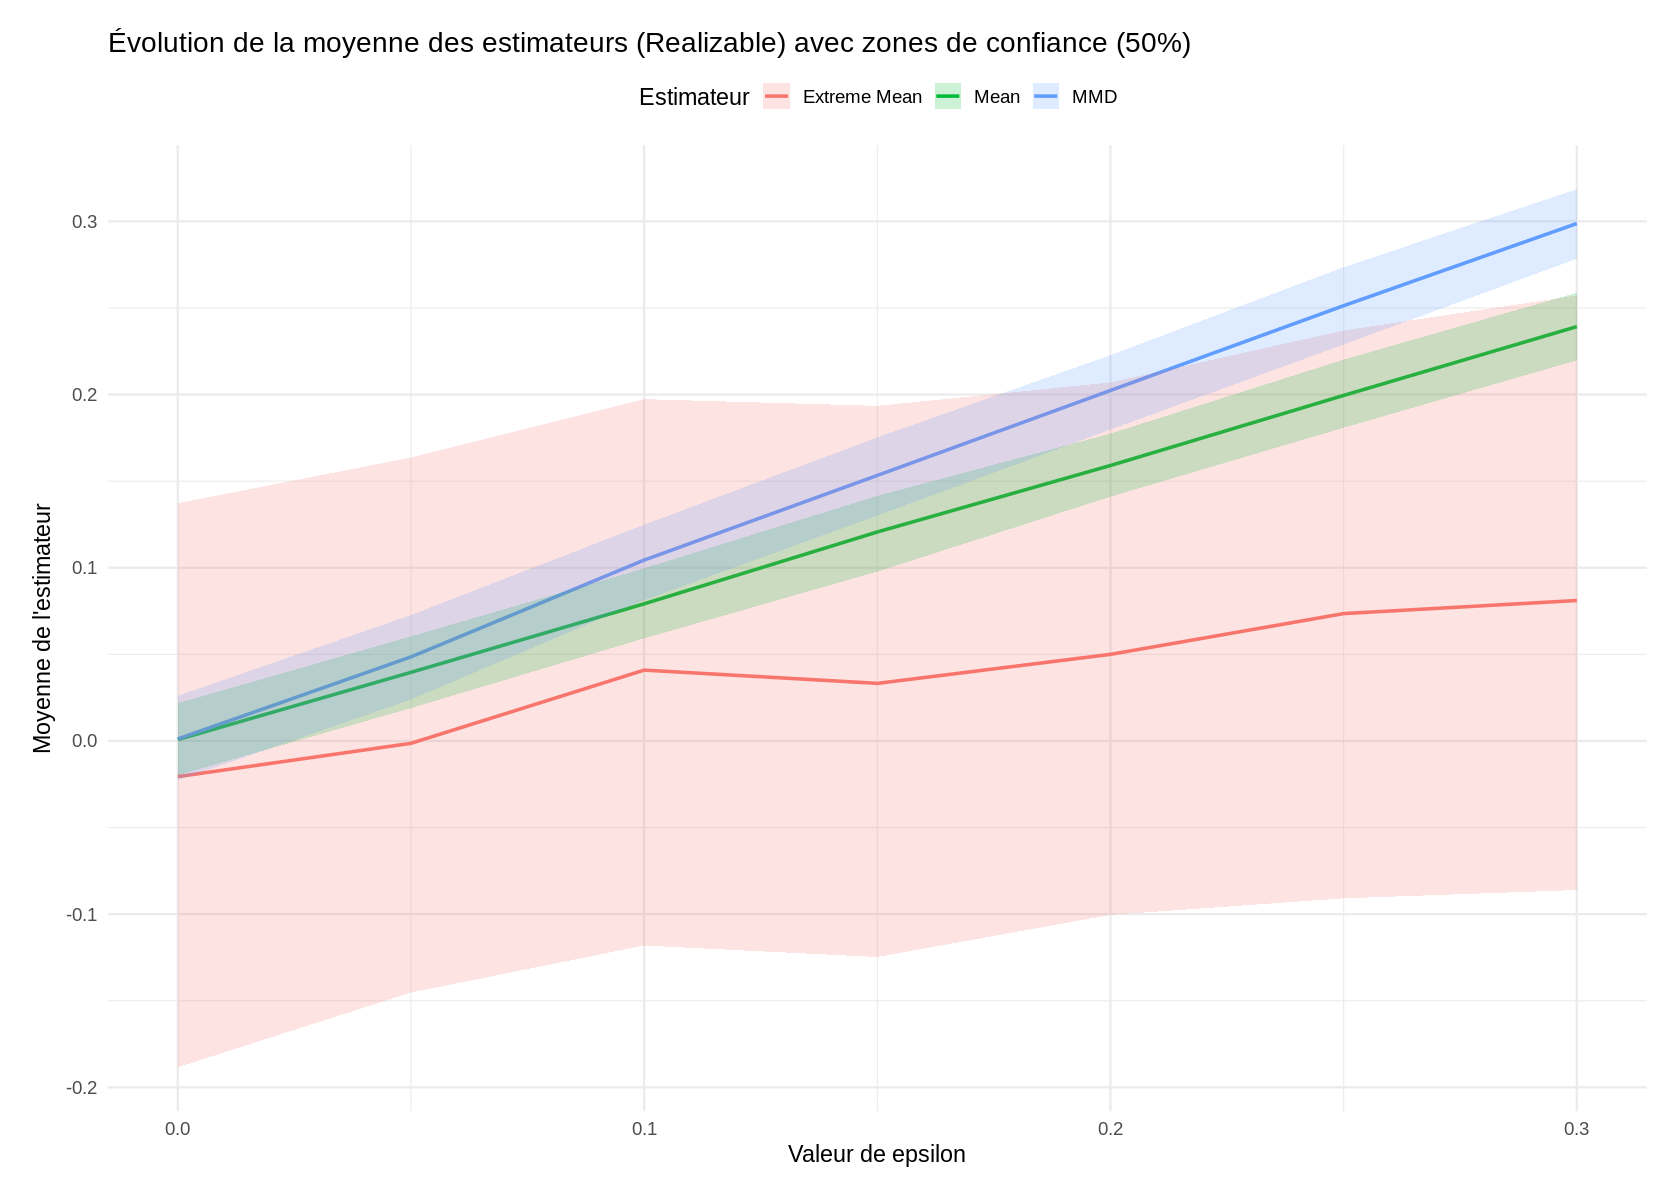

In [ ]:
# Fonction pour calculer les quartiles de l'estimateur Mean (réalisable)
calculate_mean_quartiles_realizable <- function(epsilon, n, num_repetitions, alpha) {
  mean_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimateur Mean
    mean_estimators[i] <- mean(X[M == 1])
  }

  mean_val <- mean(mean_estimators)
  lower_quartile <- quantile(mean_estimators, 0.25)
  upper_quartile <- quantile(mean_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur des extrêmes (réalisable)
calculate_extreme_mean_quartiles_realizable <- function(epsilon, n, num_repetitions, alpha) {
  extreme_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimation des extrêmes (maximum et minimum)
    max_value <- max(X[M == 1])
    min_value <- min(X[M == 1])

    # Moyenne des extrêmes
    extreme_estimators[i] <- (max_value + min_value) / 2
  }

  extreme_val <- mean(extreme_estimators)
  lower_quartile <- quantile(extreme_estimators, 0.25)
  upper_quartile <- quantile(extreme_estimators, 0.75)

  return(c(extreme_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur MMD (réalisable)
calculate_mmd_quartiles_realizable <- function(epsilon, n, num_repetitions, alpha) {
  mmd_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    n1 <- as.integer((1 - epsilon) * n)
    X1 <- rnorm(n1, 0, 1)
    M1 <- rbinom(n1, 1, alpha)

    n2 <- n - n1
    X2 <- rnorm(n2, 0, 1)
    M2 <- as.integer(X2 > 0)

    X <- c(X1, X2)
    M <- c(M1, M2)

    # Estimateur MMD
    Est1 <- mmd_est(X[M == 1], model = "Gaussian.loc", par2 = 1)
    mmd_estimators[i] <- Est1$estimator
  }

  mmd_val <- mean(mmd_estimators)
  lower_quartile <- quantile(mmd_estimators, 0.25)
  upper_quartile <- quantile(mmd_estimators, 0.75)

  return(c(mmd_val, lower_quartile, upper_quartile))
}

# Paramètres
epsilon_values <- seq(0, 0.3, by = 0.05)  # Valeurs de epsilon
n <- 2000  # Taille d'échantillon fixe
num_repetitions <- 500  # Nombre de répétitions
alpha <- 0.5

# Calcul des moyennes et des quartiles pour chaque epsilon
results_mean_realizable <- t(sapply(epsilon_values, calculate_mean_quartiles_realizable, n = n, num_repetitions = num_repetitions, alpha = alpha))
results_extreme_realizable <- t(sapply(epsilon_values, calculate_extreme_mean_quartiles_realizable, n = n, num_repetitions = num_repetitions, alpha = alpha))
results_mmd_realizable <- t(sapply(epsilon_values, calculate_mmd_quartiles_realizable, n = n, num_repetitions = num_repetitions, alpha = alpha))

# Préparer les données pour le graphique
df_realizable <- data.frame(
  Epsilon = rep(epsilon_values, 3),
  MeanEstimator = c(results_mean_realizable[, 1], results_extreme_realizable[, 1], results_mmd_realizable[, 1]),
  CI_Lower = c(results_mean_realizable[, 2], results_extreme_realizable[, 2], results_mmd_realizable[, 2]),
  CI_Upper = c(results_mean_realizable[, 3], results_extreme_realizable[, 3], results_mmd_realizable[, 3]),
  Estimator = rep(c("Mean", "Extreme Mean", "MMD"), each = length(epsilon_values))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
library(ggplot2)
ggplot(df_realizable, aes(x = Epsilon, y = MeanEstimator, color = Estimator, fill = Estimator)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution de la moyenne des estimateurs (Realizable) avec zones de confiance (50%)",
    x = "Valeur de epsilon",
    y = "Moyenne de l'estimateur",
    color = "Estimateur",
    fill = "Estimateur"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )

## Evolution of the estimators with ɛ in the adversarial setting

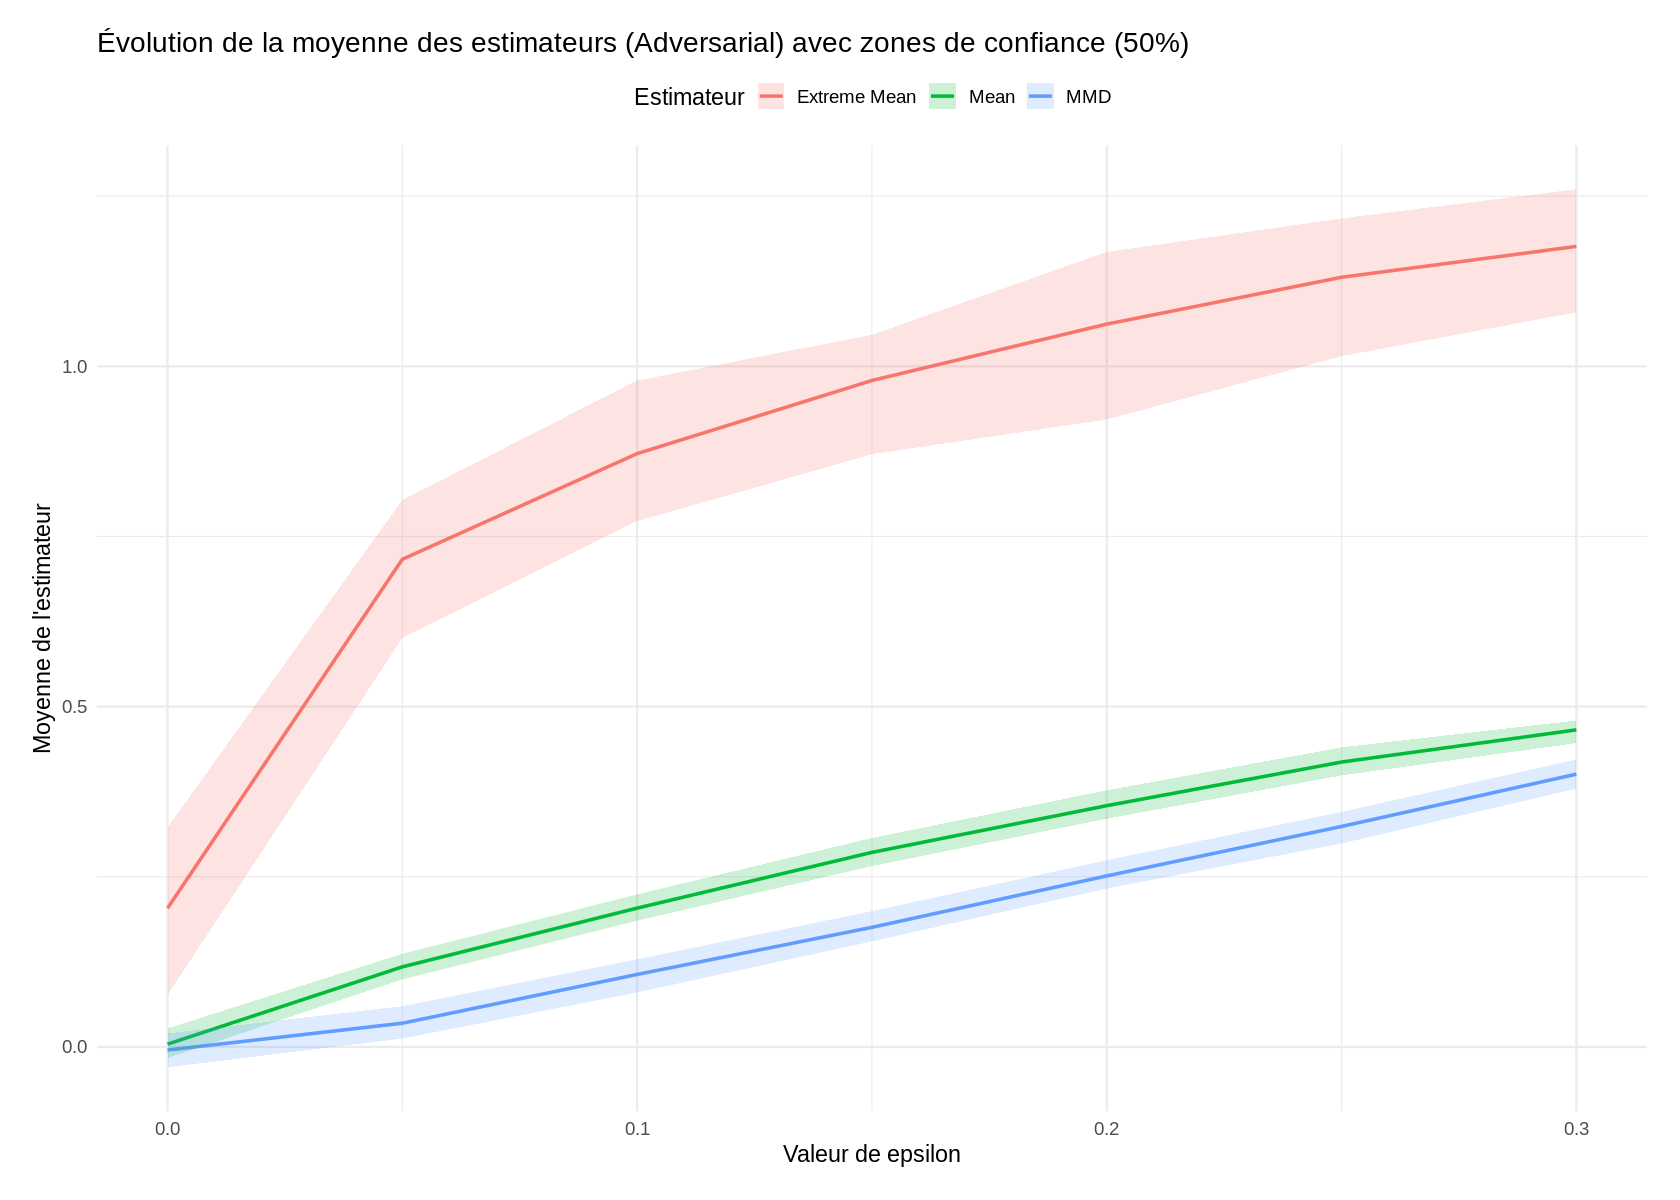

In [ ]:
# Fonction pour calculer les quartiles de l'estimateur Mean (adversarial)
calculate_mean_quartiles_adversarial_epsilon <- function(epsilon, n, num_repetitions, alpha) {
  mean_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    # Génération des données
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    # Ajustement adversarial
    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimateur Mean
    mean_estimators[i] <- mean(X[M == 1])
  }

  mean_val <- mean(mean_estimators)
  lower_quartile <- quantile(mean_estimators, 0.25)
  upper_quartile <- quantile(mean_estimators, 0.75)

  return(c(mean_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur des extrêmes (adversarial)
calculate_extreme_mean_quartiles_adversarial_epsilon <- function(epsilon, n, num_repetitions, alpha) {
  extreme_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    # Génération des données
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    # Ajustement adversarial
    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimation des extrêmes (maximum et minimum)
    max_value <- max(X[M == 1])
    min_value <- min(X[M == 1])

    # Moyenne des extrêmes
    extreme_estimators[i] <- (max_value + min_value) / 2
  }

  extreme_val <- mean(extreme_estimators)
  lower_quartile <- quantile(extreme_estimators, 0.25)
  upper_quartile <- quantile(extreme_estimators, 0.75)

  return(c(extreme_val, lower_quartile, upper_quartile))
}

# Fonction pour calculer les quartiles de l'estimateur MMD (adversarial)
calculate_mmd_quartiles_adversarial_epsilon <- function(epsilon, n, num_repetitions, alpha) {
  mmd_estimators <- numeric(num_repetitions)

  for (i in 1:num_repetitions) {
    # Génération des données
    X <- rnorm(n, 0, 1)
    M <- rbinom(n, 1, alpha)

    # Ajustement adversarial
    num_largest <- as.integer(n * epsilon / 2)
    num_smallest <- as.integer(n * epsilon / 2)

    indices_largest <- order(X, decreasing = TRUE)[1:num_largest]
    indices_smallest <- order(X)[1:num_smallest]

    M[indices_largest] <- 1
    M[indices_smallest] <- 0

    # Estimateur MMD
    Est1 <- mmd_est(X[M == 1], model = "Gaussian.loc", par2 = 1)
    mmd_estimators[i] <- Est1$estimator
  }

  mmd_val <- mean(mmd_estimators)
  lower_quartile <- quantile(mmd_estimators, 0.25)
  upper_quartile <- quantile(mmd_estimators, 0.75)

  return(c(mmd_val, lower_quartile, upper_quartile))
}

# Paramètres
epsilon_values <- seq(0, 0.3, by = 0.05)  # Valeurs de epsilon
n <- 2000  # Taille d'échantillon fixe
num_repetitions <- 100  # Nombre de répétitions
alpha <- 0.5

# Calcul des moyennes et des quartiles pour chaque epsilon
results_mean_adversarial <- t(sapply(epsilon_values, calculate_mean_quartiles_adversarial_epsilon, n = n, num_repetitions = num_repetitions, alpha = alpha))
results_extreme_adversarial <- t(sapply(epsilon_values, calculate_extreme_mean_quartiles_adversarial_epsilon, n = n, num_repetitions = num_repetitions, alpha = alpha))
results_mmd_adversarial <- t(sapply(epsilon_values, calculate_mmd_quartiles_adversarial_epsilon, n = n, num_repetitions = num_repetitions, alpha = alpha))

# Préparer les données pour le graphique
df_adversarial <- data.frame(
  Epsilon = rep(epsilon_values, 3),
  MeanEstimator = c(results_mean_adversarial[, 1], results_extreme_adversarial[, 1], results_mmd_adversarial[, 1]),
  CI_Lower = c(results_mean_adversarial[, 2], results_extreme_adversarial[, 2], results_mmd_adversarial[, 2]),
  CI_Upper = c(results_mean_adversarial[, 3], results_extreme_adversarial[, 3], results_mmd_adversarial[, 3]),
  Estimator = rep(c("Mean", "Extreme Mean", "MMD"), each = length(epsilon_values))
)

# Tracer les courbes avec zones de confiance basées sur les quartiles
ggplot(df_adversarial, aes(x = Epsilon, y = MeanEstimator, color = Estimator, fill = Estimator)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = CI_Lower, ymax = CI_Upper), alpha = 0.2, linetype = 0) +
  labs(
    title = "Évolution de la moyenne des estimateurs (Adversarial) avec zones de confiance (50%)",
    x = "Valeur de epsilon",
    y = "Moyenne de l'estimateur",
    color = "Estimateur",
    fill = "Estimateur"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    plot.margin = margin(20, 20, 20, 20)
  )